In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, QuantileTransformer, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

%matplotlib inline

# Strojové učenie 
# Sližik, Ürge (50 : 50) - dataset 027 
## Extrakcia dát
V tretej fáze budeme pracovať s predspracovanými údajmi z predošlej fázy. Pre zjednodušenie práce si zapamätáme aj pôvodnú verziu test_data. 

In [2]:
train_data = pd.read_csv('027/train_data.csv', encoding="utf_8", sep='\t')
test_data = pd.read_csv('027/test_data.csv', encoding="utf_8", sep='\t')
original_test_data = test_data.copy()

In [3]:
train_data.head()

,pct_scroll_move_duration,pct_mouse_move,wild_mouse_duration,pct_input,pct_mouse_click,ack
0,-0.427444,0.396512,-1.134733,-1.089646,-0.866340,1.0
1,-0.465760,0.397556,1.650839,1.713521,-1.653848,0.0
2,-0.334568,0.782378,0.924636,0.701521,-1.395621,0.0
3,-0.862088,0.675979,1.269531,1.060997,-1.620669,0.0
4,0.108129,0.396535,-1.465728,-1.556984,0.731588,1.0


In [4]:
test_data.head()

,pct_scroll_move_duration,pct_mouse_move,wild_mouse_duration,pct_input,pct_mouse_click,ack
0,0.665759,0.393972,-0.892841,-0.730284,-0.440761,1.0
1,-0.299346,0.782686,0.245463,0.191739,1.045414,0.0
2,1.251571,0.423408,-0.063046,-0.025710,1.386996,1.0
3,0.185782,0.400180,0.653995,0.467842,-0.195551,1.0
4,0.617054,0.073323,0.653704,0.468397,-0.018927,1.0


## 3.1 Jednoduchý klasifikátor na základe závislosti v dátach - OneR
Tento algoritmus sa rozhoduje na základe jedného atribútu na to, aby sme mohli zvoliť najlepší atribút z našich vybraných atribútov z predošlej fázy ho preto musíme zbehnúť nad každým jedným z atribútov trénovacích dát. 

Pracujeme s numerickými hodnotami, a preto je potrebné vždy najskôr daný stĺpec prerozdeliť do binov - my sme sa rozhodli pre najjednoduchší spôsob určenia binov, prerozdeliť ich na `n` rovnakých intervalov. Skúšali sme viaceré možné `n` a najlepšie sa nám osvedčila hodnota `n=10`. 

Program počíta počty výskytov `ack=1` a `ack=0` v danom bine a rozhoduje na základe vyššieho počtu. Ak je v intervale viac `ack=1`, priradí sa pozitívny ack. Vytvára sa pravidlo, že ak je tento atribút prítomný v danom bine, je ohodnotený ako `ack=1`.

Pre zjednodušenie výpočtu metrík úspešnosti sme do tabuľky pridali stĺpec predicted_ack. Metriky úspešnosti z knižnice sklearn.metrics zahŕňajú:

T - True | F - False | P - Positive | N - Negative
* `accuracy` - celková správnosť modelu (TP+TN)/(TP+TN+FP+FN)
* `precision` - presnosť modelu (TP)/(TP+FP)
* `recall` - úspešnosť v odhalení chybných hodnotení (TP)/(TP+FN)

In [5]:
def determine_dominant_label(contingency_table):
    contingency_table['predicted_ack'] = contingency_table[[0.0, 1.0]].idxmax(axis=1)
    return contingency_table['predicted_ack'].values

def map_labels_to_dataframe(data, feature_column, labels_array):
    data['predicted_ack'] = data[feature_column].map(dict(enumerate(labels_array))).astype(float).fillna(0.0)
    return data

def visualize_statistics(data, feature_column1, feature_column2):
    accuracy = accuracy_score(data['ack'], data['predicted_ack'])
    precision = precision_score(data['ack'], data['predicted_ack'])
    recall = recall_score(data['ack'], data['predicted_ack'])

    if feature_column2:
        print(f"{feature_column1} {feature_column2}\naccuracy {accuracy}\nprecision {precision}\nrecall {recall}\n\n")
    else:
        print(f"{feature_column1}\naccuracy {accuracy}\nprecision {precision}\nrecall {recall}\n\n")

    return accuracy, precision, recall

def one_r(data, feature_column):
    data[feature_column] = pd.cut(data[feature_column], labels=False, bins=10)

    contingency_table = pd.crosstab(data[feature_column], data['ack'])
    labels_array = determine_dominant_label(contingency_table)
    data = map_labels_to_dataframe(data, feature_column, labels_array)

    return visualize_statistics(data, feature_column, None)

In [6]:
best_accuracy, best_precision, best_recall = 0, 0, 0
best_feature_accuracy, best_feature_precision, best_feature_recall = "", "", ""

for column in list(test_data.columns)[:-1]:
    accuracy, precision, recall = one_r(test_data, column)
    if accuracy > best_accuracy:
        best_accuracy, best_feature_accuracy = accuracy, column
    if precision > best_precision:
        best_precision, best_feature_precision = precision, column
    if recall > best_recall:
        best_recall, best_feature_recall = recall, column

pct_scroll_move_duration
accuracy 0.8576470588235294
precision 0.9097387173396675
recall 0.8218884120171673


pct_mouse_move
accuracy 0.8729411764705882
precision 0.8776371308016878
recall 0.8927038626609443


wild_mouse_duration
accuracy 0.5670588235294117
precision 0.5696022727272727
recall 0.8605150214592274


pct_input
accuracy 0.548235294117647
precision 0.5483490566037735
recall 0.9978540772532188


pct_mouse_click
accuracy 0.62
precision 0.604075691411936
recall 0.8905579399141631



### Najlepšie metriky sme dosiahli v nasledujúcich stĺpcoch
Potvrdilo sa z predošlých fáz, že najpodstatnejší je pre nás atribút pct_mouse_move, ktorý má najvyššiu accuracy ak je použitý v OneR.

In [7]:
print(f"best accuracy {best_accuracy} ({best_feature_accuracy})")
print(f"best precision {best_precision} ({best_feature_precision})")
print(f"best recall {best_recall} ({best_feature_recall})")

best accuracy 0.8729411764705882 (pct_mouse_move)
best precision 0.9097387173396675 (pct_scroll_move_duration)
best recall 0.9978540772532188 (pct_input)


## Rozhodnutie na základe viac atribútov pomocou OneR
Postupne analyzujeme každú dvojicu atribútov s cieľom nájsť optimálnu kombináciu pre `accuracy`, `precision`, `recall`

V prvom kroku vyhodnocujeme, s akou dôležitosťou každý atribút prispieva k rozhodovaniu. Vytvárame pole s veľkosťou rovnakou, ako počet binov, intervalov `n=10`. Každý index reprezentuje konkrétny interval, pričom hodnoty v poli sú dvojice [ack=0/1, váha=počet_za/celkový_počet].

V závere prechádzame naše dáta pozeráme sa na hodnotu binu do ktorého patrí atribút1 a následne atribút2 - pozrieme sa do polia váh ak sa ohodnotenie ack zhoduje pre dané biny priradíme mu príslušnú hodnotu.´V prípade nezhody porovnávame váhy a priradzujeme hodnotu s vyššou váhou.

In [8]:
def calculate_weights(data, feature_column):
    data[feature_column] = pd.cut(data[feature_column], labels=False, bins=10)
    contingency_table = pd.crosstab(data[feature_column], data['ack'])
    weight_arr = []
    for index, row in contingency_table.iterrows():
        if index+1 > len(weight_arr):
            weight_arr.append([1, 0])
        
        sum = row[0] + row[1]
        wanted = row[1]
        ack_val = 1
        if row[0] > row[1]:
            wanted = row[0]
            ack_val = 0
        weight_arr.append([ack_val, wanted/sum])
        
    return weight_arr

def one_r_multiple_features(columns):
    best_metrics = {
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'feature_accuracy1': "",
        'feature_accuracy2': "",
        'feature_precision1': "",
        'feature_precision2': "",
        'feature_recall1': "",
        'feature_recall2': ""
    }

    for col_index_i in range(len(columns)):
        for col_index_j in range(col_index_i + 1, len(columns)):
            weighted_bins_column1 = calculate_weights(test_data, columns[col_index_i])
            weighted_bins_column2 = calculate_weights(test_data, columns[col_index_j])

            # iterate over test_data and assign predicted value based on weights 
            for index, row in test_data.iterrows():
                weight1 = weighted_bins_column1[int(row[col_index_i])]
                weight2 = weighted_bins_column2[int(row[col_index_j])]

                if weight1[0] == weight2[0]:
                    test_data.at[index, 'predicted_ack'] = float(weight1[0])
                elif weight1[1] > weight2[1]:
                    test_data.at[index, 'predicted_ack'] = float(weight1[0])
                else:
                    test_data.at[index, 'predicted_ack'] = float(weight2[0])

            accuracy, precision, recall = visualize_statistics(test_data, columns[col_index_i], columns[col_index_j])
            if accuracy > best_metrics['accuracy']:
                best_metrics['accuracy'] = accuracy
                best_metrics['feature_accuracy1'] = columns[col_index_i]
                best_metrics['feature_accuracy2'] = columns[col_index_j]
            if precision > best_metrics['precision']:
                best_metrics['precision'] = precision
                best_metrics['feature_precision1'] = columns[col_index_i]
                best_metrics['feature_precision2'] = columns[col_index_j]
            if recall > best_metrics['recall']:
                best_metrics['recall'] = recall
                best_metrics['feature_recall1'] = columns[col_index_i]
                best_metrics['feature_recall2'] = columns[col_index_j]
    return best_metrics

best_metrics = one_r_multiple_features(list(test_data.columns)[:-2])

pct_scroll_move_duration pct_mouse_move
accuracy 0.8976470588235295
precision 0.8891170431211499
recall 0.9291845493562232


pct_scroll_move_duration wild_mouse_duration
accuracy 0.7047058823529412
precision 0.8825622775800712
recall 0.5321888412017167

pct_scroll_move_duration pct_input
accuracy 0.6905882352941176
precision 0.8918918918918919
recall 0.4957081545064378

pct_scroll_move_duration pct_mouse_click
accuracy 0.7588235294117647
precision 0.887240356083086
recall 0.6416309012875536

pct_mouse_move wild_mouse_duration
accuracy 0.8141176470588235
precision 0.7566666666666667
recall 0.9742489270386266

pct_mouse_move pct_input
accuracy 0.8105882352941176
precision 0.7633851468048359
recall 0.9484978540772532

pct_mouse_move pct_mouse_click
accuracy 0.8164705882352942
precision 0.7636054421768708
recall 0.9635193133047211


wild_mouse_duration pct_input
accuracy 0.548235294117647
precision 0.5564738292011019
recall 0.8669527896995708

wild_mouse_duration pct_mouse_click
accuracy 0

### Najlepšie metriky pre dva atribúty sme dosiahli v nasledujúcich stĺpcoch
Podarilo sa nám nadobudnúť podstatne vyššie hodnoty `accuracy`, ako iba pri rozhodovaní sa na základe jedného atribútu, keď sme to skúšali nad trénovacími dátami získali sme aj vyššie hodnoty `precision`, keďže sa jedná o väčší dataset.

In [9]:
print(f"best accuracy {best_metrics['accuracy']} ({best_metrics['feature_accuracy1']} { best_metrics['feature_accuracy2']})")
print(f"best precision {best_metrics['precision']} ({best_metrics['feature_precision1']} {best_metrics['feature_precision2']})")
print(f"best recall {best_metrics['recall']} ({best_metrics['feature_recall1']} {best_metrics['feature_recall2']})")

best accuracy 0.8976470588235295 (pct_scroll_move_duration pct_mouse_move)
best precision 0.8918918918918919 (pct_scroll_move_duration pct_input)
best recall 0.9742489270386266 (pct_mouse_move wild_mouse_duration)


## 3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia
V tejto časti sme sa rozhodli porovnať klasifikátory medzi sebou a s OneR:
* LogisticRegression
* DecisionTree 
* RandomForest
 
### Prvotná príprava
Rozdelíme si trénovacie a testovacie dáta na stĺpce s `ack` a bez `ack`.
Zadefinujeme pomocné funkcie na vykreslenie stromov a ohodnotenie modelu.
Na ohodnotenie použijeme okrem metrík úspešnosti aj ConfusionMatrix, vizuálnu reprezentáciu výkonu modelu. Naším cieľom je dosiahnuť čo najvyššie hodnoty v ľavom hornom rohu, kde sa nachádzajú hodnoty TP - true positive a pravom dolnom rohu TN - true negative. Naopak, hodnoty v pravom hornom rohu FP - False Positive a ľavom dolnom rohu FN - False Negative by mali byť čo najnižšie.

In [10]:
test_data = original_test_data.copy()
train_X = train_data.drop('ack', axis=1)
train_y = train_data['ack']

test_X = test_data.drop('ack', axis=1)
test_y = test_data['ack']

def save_visualize_tree(classifier, feature_names, image_filename, class_names=None):
    plt.figure(figsize=(20, 10))
    plot_tree(classifier, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, proportion=True, impurity=False)
    plt.savefig(image_filename)
    plt.show()

def evaluate_classifier(classifier, test_X, test_y):
    predictions = classifier.predict(test_X)
    report = classification_report(test_y, predictions, digits=4)
    print(report)
    return predictions

def plot_confusion_matrix(test_y, predicted_y):
    conf_matrix = confusion_matrix(test_y, predicted_y)
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Model Evaluation - Confusion Matrix')
    plt.show()

## LogisticRegression
 Slúži na modelovanie vzťahu medzi jedným alebo viacerými nezávislými premennými a závislou premennou tak, aby sme mohli predikovať hodnoty závislej premennej pre nové dáta. LogisticRegression je špecifický prípad regresie, ktorý sa používa pre klasifikačné úlohy. Namiesto toho, aby sme predikovali priamu hodnotu, ako pri LinearRegression, logistická regresia používa logistickú funkciu. 

              precision    recall  f1-score   support

         0.0     0.9267    0.9219    0.9243       384
         1.0     0.9359    0.9399    0.9379       466

    accuracy                         0.9318       850
   macro avg     0.9313    0.9309    0.9311       850
weighted avg     0.9317    0.9318    0.9317       850


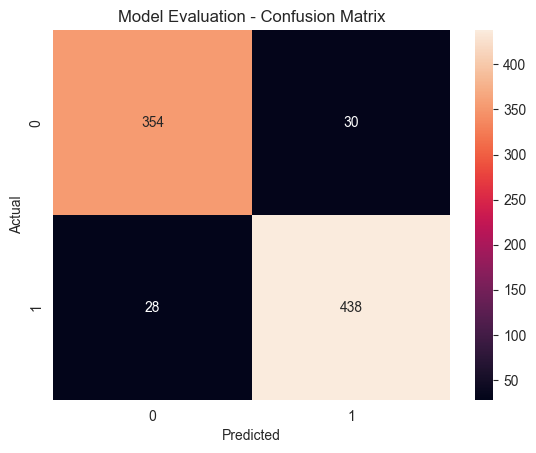

In [11]:
def train_logistic_regression(train_X, train_y, max_iter, random_state):
    lr_classifier = LogisticRegression(max_iter=max_iter, random_state=random_state)
    lr_classifier.fit(train_X, train_y)
    return lr_classifier

lr_classifier = train_logistic_regression(train_X, train_y, 1024, 64)
ack_predicted_logistic_regression = evaluate_classifier(lr_classifier, test_X, test_y)
plot_confusion_matrix(test_y, ack_predicted_logistic_regression)

## DecisionTree 
Algoritmus často využívaný v strojovom učení pre klasifikačné aj regresné úlohy. Pracuje na princípe rekurzívneho rozdeľovania vstupných dát. Na každej úrovni stromu sa vyberie najlepšia vlastnosť na rozdelenie údajov, a proces pokračuje, kým nie je splnená podmienka, napríklad dosiahnutie maximálnej hĺbky stromu. Rozhodovacie stromy majú výhodu interpretovateľnosti, čo umožňuje užívateľom ľahko pochopiť a vizualizovať rozhodovací proces. Avšak môžu byť náchylné na pretrénovanie, najmä s hlbokými stromami, ktoré môžu zachytiť šum v trénovacích dátach.

              precision    recall  f1-score   support

         0.0     0.9321    0.9297    0.9309       384
         1.0     0.9422    0.9442    0.9432       466

    accuracy                         0.9376       850
   macro avg     0.9371    0.9369    0.9370       850
weighted avg     0.9376    0.9376    0.9376       850


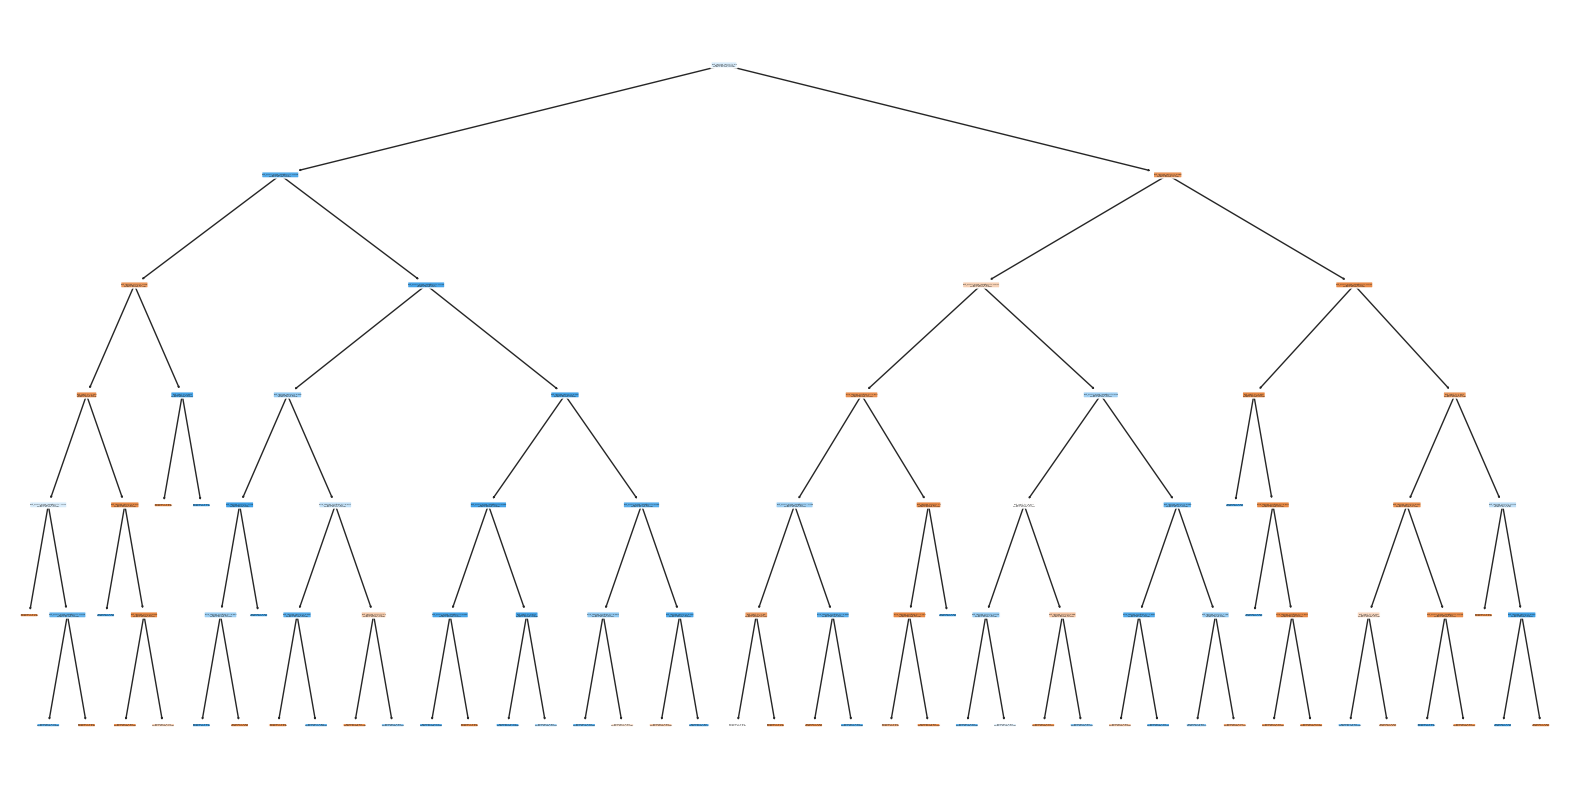

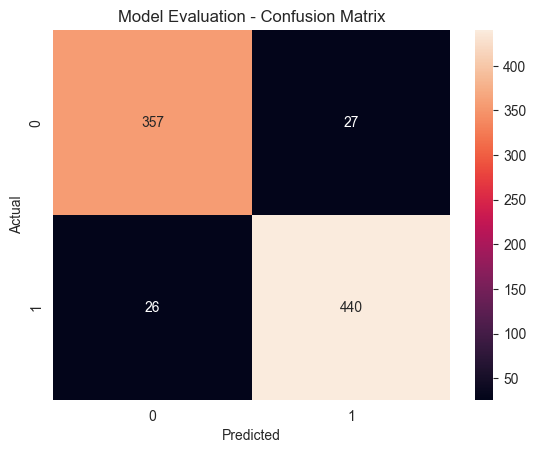

In [12]:
def train_decision_tree(train_X, train_y, max_depth, random_state):
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    dt_classifier.fit(train_X, train_y)
    return dt_classifier

dt_classifier = train_decision_tree(train_X, train_y, 6, 64)
ack_predicted_decision_tree = evaluate_classifier(dt_classifier, test_X, test_y)
save_visualize_tree(dt_classifier, train_data.columns, 'decision_tree')
plot_confusion_matrix(test_y, ack_predicted_decision_tree)

## RandomForest
Rozšírenie konceptu DecisionTree, strom nie je iba jeden, ale vytvorí sa zoskupenie, ktoré pracuje kolektívne na riešení úlohy klasifikácie alebo regresie. Tento algoritmus využíva techniku ensemble learning, kde viacero modelov je kombinovaných s cieľom dosiahnuť lepšiu prediktívnu presnosť. V prípade klasifikácie sa výsledky jednotlivých stromov spoja hlasovaním, kde sa vyberie najčastejšia trieda. Pri regresii sa výsledky priemerujú. Výhodou je, že RandomForest je odolný voči pretrénovaniu a je schopný pracovať s veľkým množstvom atribútov. 

Pri vizualizácií zobrazujeme iba jeden zo stromov.

              precision    recall  f1-score   support

         0.0     0.9420    0.9297    0.9358       384
         1.0     0.9427    0.9528    0.9477       466

    accuracy                         0.9424       850
   macro avg     0.9423    0.9412    0.9417       850
weighted avg     0.9423    0.9424    0.9423       850


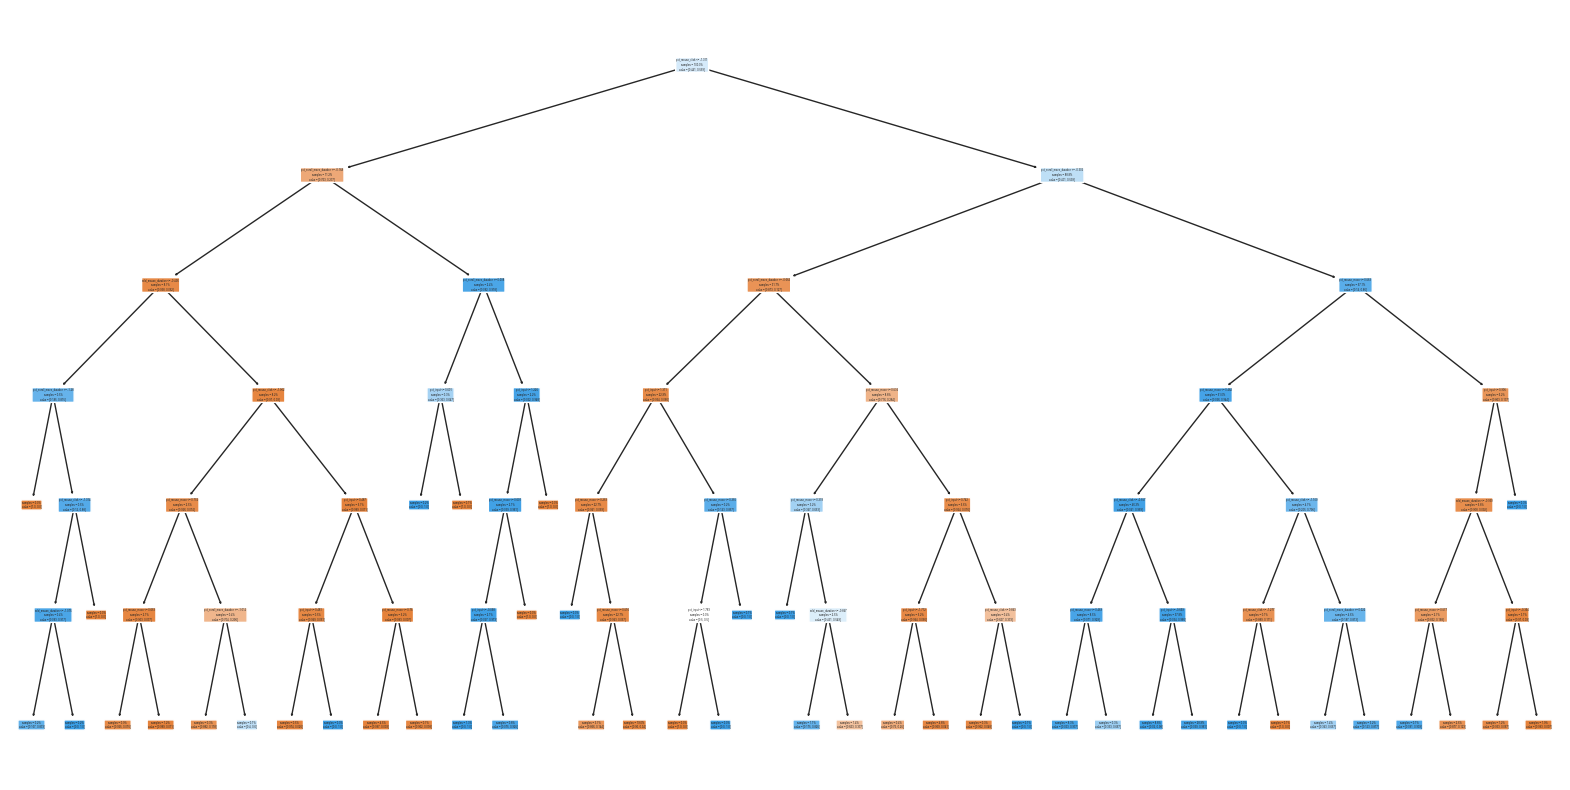

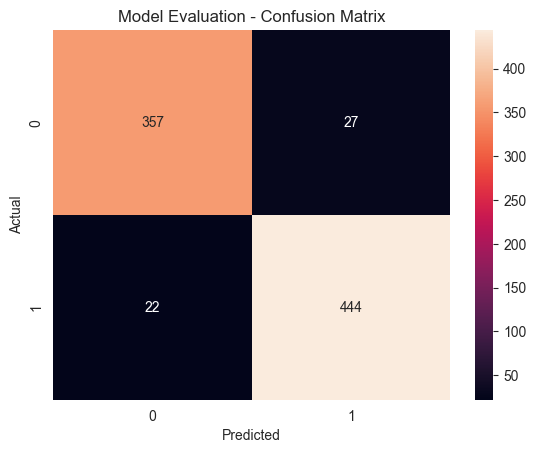

In [13]:
def train_random_forest(train_X, train_y, n_estimators, max_depth, random_state):
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_classifier.fit(train_X, train_y)
    return rf_classifier


rf_classifier = train_random_forest(train_X, train_y, 100, 6, 64)
ack_predicted_random_forest = evaluate_classifier(rf_classifier, test_X, test_y)
save_visualize_tree(rf_classifier.estimators_[42], train_data.columns, 'random_forest')
plot_confusion_matrix(test_y, ack_predicted_random_forest)

### Záver porovnania
Všetky vybrané klasifikátory strojového učenia dosahujú lepšie výsledky než OneR bez zložitého nastavovania parametrov. Tieto metódy ponúkajú väčšiu flexibilitu a môžu byť vylepšené prostredníctvom optimálnych nastavení. Z hľadiska odolnosti voči pretrénovaniu a schopnosti pracovať s viacerými atribútmi je RandomForest najspoľahlivejší. Napriek tomu má svoje nevýhody, ako dlhšie trvanie tréningu a zložitejšiu interpretáciu funguje ako nevysvetliteľný black box narozdiel od jednoduchších metód, ako sú DecisionTree alebo LogisticRegression. Je nejasné, na aké presné atribúty sa pri rozhodovaní pozerá.

Najlepšiu accuracy so základnými parametrami sme dosiahli pri RandomForest.

## 3.3 Optimalizácia alias hyperparameter tuning
V tejto časti sa pokúsime nájsť čo najlepšie parametre pre RandomForest. Algoritmus, ktorý už so základnými parametrami dosahoval najlepšie výsledky. Vyskúšame rôzne kombinácie s cieľom minimalizovať preučenie a maximalizovať accuracy:
* `criterion`: funkcia na meranie kvality rozdelenia
* `max_depth`: maximálna hĺbka stromu
* `min_samples_split`: minimálny počet potrebný na rozdelenie vnútorného uzlu
* `min_samples_leaf`: minimálny počet vzoriek na listovom uzle

Pri volaní GridSearch hyperparameter tuningu použijeme parameter cv, teda krížovú validáciu. Ktorý rozdelí dataset do k skupín, podmnožín, model je trénovaný na k-1 skupinách a validovaný na zostávajúcej skupine. Tento proces sa opakuje k-krát, pričom každá skupina slúži ako validačná sada práve raz výsledky výkonu sa priemerujú, aby sme získali spoľahlivejší odhad výkonu modelu.

In [14]:
def tune_random_forest_hyperparameters(train_X, train_y):
    hyperparameters = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [8, 10, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [64]
    }

    classifier = RandomForestClassifier()
    grid_search = GridSearchCV(classifier, hyperparameters, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(train_X, train_y)
    
    return grid_search

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 64}
              precision    recall  f1-score   support

         0.0     0.9423    0.9349    0.9386       384
         1.0     0.9467    0.9528    0.9497       466

    accuracy                         0.9447       850
   macro avg     0.9445    0.9438    0.9441       850
weighted avg     0.9447    0.9447    0.9447       850


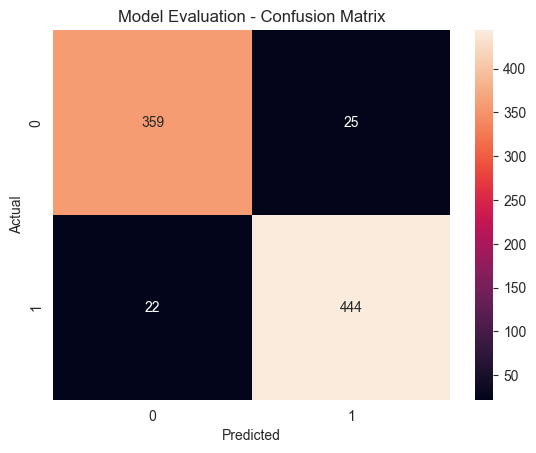

In [15]:
grid_search_result = tune_random_forest_hyperparameters(train_X, train_y)
best_params = grid_search_result.best_params_
best_model = grid_search_result.best_estimator_

print("Best hyperparameters:", best_params)
best_predictions = evaluate_classifier(best_model,test_X, test_y)
plot_confusion_matrix(test_y, best_predictions)

## 3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu
Pre túto fázu sme sa rozhodli využívať výhradne RandomForest, keďže sa nám vďaka nemu podarilo nájsť najlepšie výsledky, využíva `ensemble learning` - teda na to, aby sa dopracoval k odpovedi využíva zhodu viacero DecisionTree modelov, je vďaka tomu taktiež imúnny voči pretrénovaniu. Predošlá fáza nám ukázala, že jeho defaultné parametre nestačia a je potrebné použiť GridSearch pre optimalizáciu, takže pri porovnaní zavoláme vždy GridSearch s rovankými hyperparametrami z predošlej fázy, aby sme zistili aký dopad budú mať na výsledky rôzne metódy využité pri preprocessingu: 
* riešenie chýbajúcich hodnôt - median vs mean
* riešenie outlierov - iqr vs std
* transformácie - s transformáciami vs bez transformácie
* výber atribútov - rfe vs k best

In [16]:
def drop_extra(dataframe, selected_columns):
    return dataframe[selected_columns]

def replace_null_with_mean(dataframe, columns_with_missing_values):
    mean_values = dataframe[columns_with_missing_values].mean()
    result_dataframe = dataframe.copy()
    result_dataframe[columns_with_missing_values] = result_dataframe[columns_with_missing_values].fillna(mean_values)
    return result_dataframe

def replace_null(dataframe, columns_with_missing_values, method_median):
    result_dataframe = dataframe.copy()

    if method_median:
        median_values = dataframe[columns_with_missing_values].median()
        result_dataframe[columns_with_missing_values] = result_dataframe[columns_with_missing_values].fillna(median_values)
    else:
        mean_values = dataframe[columns_with_missing_values].mean()
        result_dataframe[columns_with_missing_values] = result_dataframe[columns_with_missing_values].fillna(mean_values)

    return result_dataframe

def remove_outliers(dataframe, columns, method_iqr, threshold=1.5):
    cleaned_dataframe = dataframe.copy()

    if method_iqr:
        # IQR
        for column_name in columns:
            Q1 = cleaned_dataframe[column_name].quantile(0.25)
            Q3 = cleaned_dataframe[column_name].quantile(0.75)
            IQR = Q3 - Q1

            outliers = (cleaned_dataframe[column_name] < (Q1 - threshold * IQR)) | (cleaned_dataframe[column_name] > (Q3 + threshold * IQR))
            cleaned_dataframe = cleaned_dataframe.loc[~outliers]
    else:
        # STD
        for column in columns:
            column_mean, column_std = np.mean(cleaned_dataframe[column]), np.std(cleaned_dataframe[column])
            low = column_mean - column_std * 3
            high = column_mean + column_std * 3
            cleaned_dataframe = cleaned_dataframe.loc[(cleaned_dataframe[column] > low) & (cleaned_dataframe[column] < high)]

    return cleaned_dataframe

def apply_scaler(dataframe, column_name, scaler):
    dataframe[column_name] = scaler.fit_transform(dataframe[[column_name]])
    return dataframe

def apply_scaler_to_columns(dataframe, columns, scaler, do_transformation):
    if do_transformation:
        for column in columns:
            dataframe = apply_scaler(dataframe, column, scaler)
    return dataframe

def replicate_preprocessing(rfe_selection = True, method_median = True, method_iqr = True, do_transformation = True):
    sessions = pd.read_csv("027/session.csv", encoding="utf_8", sep='\t')
    train_data, test_data= train_test_split(sessions, test_size=0.1, random_state=1)

    minmax_columns = ["pct_mouse_move"]
    transformer_columns = ["pct_scroll_move_duration", "pct_mouse_click"]
    quantile_columns = ["pct_input"]

    if rfe_selection:
        selected_columns = [
            "pct_scroll_move_duration",
            "pct_mouse_move",
            "wild_mouse_duration",
            "pct_input",
            "pct_mouse_click",
        ]
        transformer_columns.append("wild_mouse_duration")
    else:
        selected_columns = [
            "pct_scroll_move_duration",
            "pct_mouse_move",
            "scroll_move_total_rel_distance",
            "pct_input",
            "pct_mouse_click",
        ]
        
    selected_columns.append("ack")

    development_pipeline = Pipeline([
        ('drop_extra', FunctionTransformer(drop_extra, kw_args={"selected_columns": selected_columns})),
        ('replace_null', FunctionTransformer(replace_null, kw_args={"columns_with_missing_values": selected_columns[:-1], "method_median": method_median})),
        ('remove_outliers', FunctionTransformer(remove_outliers, kw_args={"columns": selected_columns[:-1], "method_iqr" : method_iqr})),
        ('quantile', FunctionTransformer(apply_scaler_to_columns, kw_args={"columns": quantile_columns, "scaler": QuantileTransformer(output_distribution="normal", n_quantiles=10, random_state=42), "do_transformation" : do_transformation})),
        ('power', FunctionTransformer(apply_scaler_to_columns, kw_args={"columns": transformer_columns, "scaler": PowerTransformer(), "do_transformation": do_transformation})),
        ('minmax', FunctionTransformer(apply_scaler_to_columns, kw_args={"columns": minmax_columns, "scaler": MinMaxScaler(), "do_transformation": do_transformation})),
    ], verbose=True)

    development_pipeline.fit(train_data)
    train_data_processed = development_pipeline.transform(train_data)
    test_data_processed = development_pipeline.transform(test_data)

    train_X = train_data_processed.drop('ack', axis=1)
    train_y = train_data_processed['ack']

    test_X = test_data_processed.drop('ack', axis=1)
    test_y = test_data_processed['ack']

    grid_search_result = tune_random_forest_hyperparameters(train_X, train_y)
    best_params = grid_search_result.best_params_
    best_model = grid_search_result.best_estimator_

    print("Best hyperparameters:", best_params)
    best_predictions = evaluate_classifier(best_model,test_X, test_y)
    plot_confusion_matrix(test_y, best_predictions)
    return best_model, development_pipeline


[Pipeline] ........ (step 1 of 6) Processing drop_extra, total=   0.0s
[Pipeline] ...... (step 2 of 6) Processing replace_null, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing remove_outliers, total=   0.0s
[Pipeline] .......... (step 4 of 6) Processing quantile, total=   0.0s
[Pipeline] ............. (step 5 of 6) Processing power, total=   0.0s
[Pipeline] ............ (step 6 of 6) Processing minmax, total=   0.0s
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 64}
              precision    recall  f1-score   support

         0.0     0.9429    0.9252    0.9340       428
         1.0     0.9385    0.9531    0.9457       512

    accuracy                         0.9404       940
   macro avg     0.9407    0.9392    0.9398       940
weighted avg     0.9405    0.9404    0.9404       940


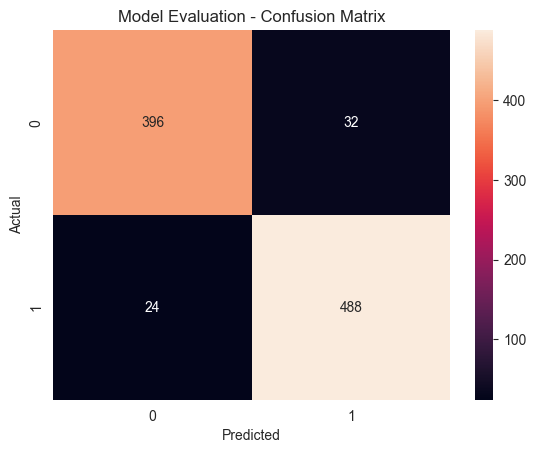

In [17]:
default_model = replicate_preprocessing()

### Median vs Mean
Metóda riešenia chýbajúcich hodnôt pomocou meanu sa nám osvedčila ako lepšia (median_accuracy=0.9424).

[Pipeline] ........ (step 1 of 6) Processing drop_extra, total=   0.0s
[Pipeline] ...... (step 2 of 6) Processing replace_null, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing remove_outliers, total=   0.0s
[Pipeline] .......... (step 4 of 6) Processing quantile, total=   0.0s
[Pipeline] ............. (step 5 of 6) Processing power, total=   0.1s
[Pipeline] ............ (step 6 of 6) Processing minmax, total=   0.0s
Best hyperparameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 64}
              precision    recall  f1-score   support

         0.0     0.9454    0.9299    0.9376       428
         1.0     0.9422    0.9551    0.9486       512

    accuracy                         0.9436       940
   macro avg     0.9438    0.9425    0.9431       940
weighted avg     0.9436    0.9436    0.9436       940


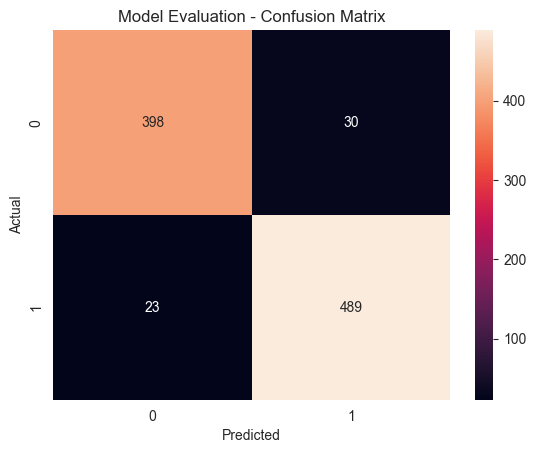

In [18]:
mean_model = replicate_preprocessing(method_median = False)

### IQR vs STD
Metóda riešenie outlierov pomocou IQR sa nám osvedčila ako lepšia (iqr_accuracy=0.9424).

[Pipeline] ........ (step 1 of 6) Processing drop_extra, total=   0.0s
[Pipeline] ...... (step 2 of 6) Processing replace_null, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing remove_outliers, total=   0.0s
[Pipeline] .......... (step 4 of 6) Processing quantile, total=   0.0s
[Pipeline] ............. (step 5 of 6) Processing power, total=   0.0s
[Pipeline] ............ (step 6 of 6) Processing minmax, total=   0.0s
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 64}
              precision    recall  f1-score   support

         0.0     0.9298    0.9356    0.9326       481
         1.0     0.9481    0.9433    0.9457       600

    accuracy                         0.9399      1081
   macro avg     0.9389    0.9394    0.9392      1081
weighted avg     0.9399    0.9399    0.9399      1081


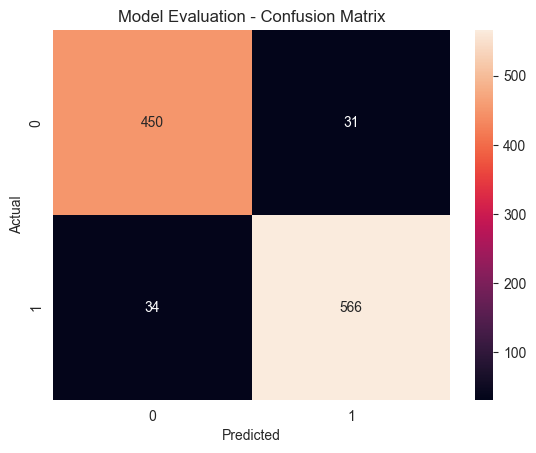

In [19]:
std_model = replicate_preprocessing(method_iqr = False)

### S transformáciami vs bez transformácií
Transformácie mali nízky dopad na samotnú `accuracy` modelu, avšak rozhodli sme sa ich vo finále predsa ponechať (with_transformations_accuracy=0.9424).

[Pipeline] ........ (step 1 of 6) Processing drop_extra, total=   0.0s
[Pipeline] ...... (step 2 of 6) Processing replace_null, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing remove_outliers, total=   0.0s
[Pipeline] .......... (step 4 of 6) Processing quantile, total=   0.0s
[Pipeline] ............. (step 5 of 6) Processing power, total=   0.0s
[Pipeline] ............ (step 6 of 6) Processing minmax, total=   0.0s
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 64}
              precision    recall  f1-score   support

         0.0     0.9388    0.9322    0.9355       428
         1.0     0.9437    0.9492    0.9464       512

    accuracy                         0.9415       940
   macro avg     0.9413    0.9407    0.9410       940
weighted avg     0.9415    0.9415    0.9415       940


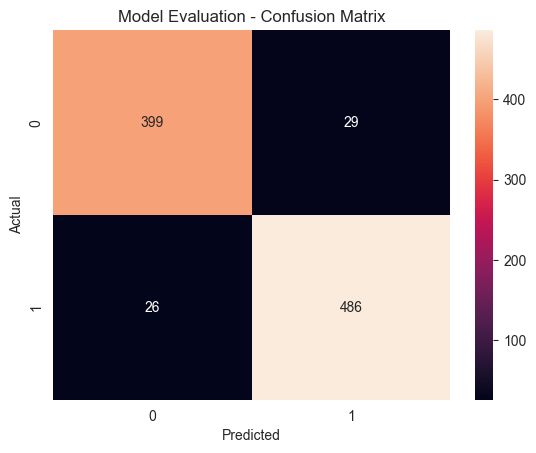

In [20]:
no_transformer_model = replicate_preprocessing(do_transformation=False)

### Výber atribútov - RFE vs K Best
Keďže sa líšili iba v jednom atribúte samotný rozdiel medzi nimi nebol v závere až taký signifikantný, takže sme sa rozhodli vo finále ponechať výber na základe RFE (rfe_accuracy=0.9424).

[Pipeline] ........ (step 1 of 6) Processing drop_extra, total=   0.0s
[Pipeline] ...... (step 2 of 6) Processing replace_null, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing remove_outliers, total=   0.0s
[Pipeline] .......... (step 4 of 6) Processing quantile, total=   0.0s
[Pipeline] ............. (step 5 of 6) Processing power, total=   0.0s
[Pipeline] ............ (step 6 of 6) Processing minmax, total=   0.0s
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 64}
              precision    recall  f1-score   support

         0.0     0.9465    0.9284    0.9373       419
         1.0     0.9421    0.9569    0.9494       510

    accuracy                         0.9440       929
   macro avg     0.9443    0.9426    0.9434       929
weighted avg     0.9441    0.9440    0.9440       929


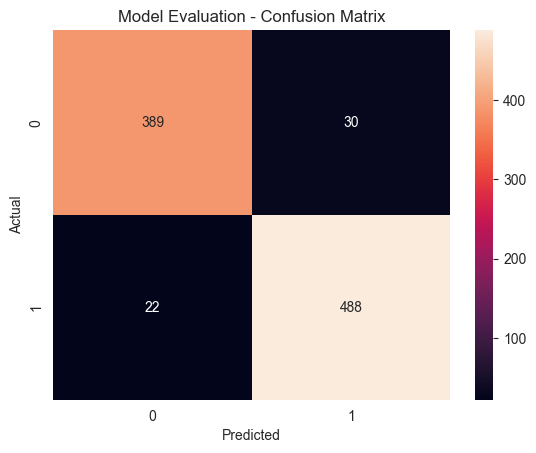

In [21]:
k_best_model = replicate_preprocessing(rfe_selection=False)

## Príklad využitia najlepšieho modelu pomocou nasadenia deployment pipeline pre ohodnotenie nových dát
V závere používame RandomForestClassifier s hyperparametrami: 
* 'criterion': 'entropy'
* 'max_depth': 10
* 'min_samples_leaf': 1
* 'min_samples_split': 5
* 'random_state': 64

Classifier operuje nad dátami upravenými nasledovne:
* method_median = False 
* method_iqr = True
* do_transformation = True
* rfe_selection=True

In [22]:
def evaluate_unseen_data(model, pipeline, unseen_data):
    unseen_data_processed = pipeline.transform(unseen_data)
    unseen_data_processed["predicted_ack"] = model.predict(unseen_data_processed.iloc[:, :-1])
    return unseen_data_processed

In [23]:
sessions = pd.read_csv("027/session.csv", encoding="utf_8", sep='\t')
train_data, test_data= train_test_split(sessions, test_size=0.1, random_state=1)
evaluated_data = evaluate_unseen_data(best_model, mean_model[1], test_data)
evaluated_data.head()

,pct_scroll_move_duration,pct_mouse_move,wild_mouse_duration,pct_input,pct_mouse_click,ack,predicted_ack
6846,0.664420,0.382885,-0.905196,-0.742808,-0.428240,1.0,1.0
9042,-0.297857,0.760661,0.216633,0.173510,1.036092,0.0,0.0
2939,-0.369267,0.611715,-1.613082,-1.516328,-1.888671,1.0,1.0
4257,1.248227,0.411493,-0.086514,-0.045855,1.373299,1.0,1.0
6018,0.185929,0.388919,0.617109,0.451636,-0.186973,1.0,1.0
